In [26]:
import sys
sys.path.append("../")

In [27]:
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import evaluate_btc_model_5, evaluate_fpt_model_5
from functools import partial
from model_code import *
from ta import add_all_ta_features
from ta.utils import dropna
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import inspect

In [28]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [29]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmppianq18m\tensorboard_logs


In [30]:
dataset_folder = "../dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type"

In [31]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [32]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)

folder: bullish_engulfing, 		 total: 19 images
folder: bearish_engulfing, 		 total: 15 images
folder: star_doji, 		 total: 4 images
folder: dragonfly_doji, 		 total: 1 images
folder: gravestone_doji, 		 total: 0 images
folder: morning_star, 		 total: 14 images
folder: evening_star, 		 total: 14 images
folder: hammer, 		 total: 2 images
folder: inverted_hammer, 		 total: 0 images
folder: harami_down, 		 total: 88 images
folder: harami_up, 		 total: 72 images
folder: tweezer_top, 		 total: 14 images
folder: tweezer_bottom, 		 total: 14 images
folder: marubozu, 		 total: 0 images
folder: spin, 		 total: 21 images
folder: next_3_day_up, 		 total: 44 images
folder: next_3_day_down, 		 total: 42 images


In [33]:
dataset_train = load_dataset_of_each_type_and_combine(f"{dataset_folder}/train", candle_type_and_directory_save)
total_data_train = len(dataset_train)

folder: bullish_engulfing, 		 total: 62 images
folder: bearish_engulfing, 		 total: 70 images
folder: star_doji, 		 total: 20 images
folder: dragonfly_doji, 		 total: 6 images
folder: gravestone_doji, 		 total: 11 images
folder: morning_star, 		 total: 57 images
folder: evening_star, 		 total: 54 images
folder: hammer, 		 total: 19 images
folder: inverted_hammer, 		 total: 6 images
folder: harami_down, 		 total: 368 images
folder: harami_up, 		 total: 328 images
folder: tweezer_top, 		 total: 41 images
folder: tweezer_bottom, 		 total: 37 images
folder: marubozu, 		 total: 46 images
folder: spin, 		 total: 88 images
folder: next_3_day_up, 		 total: 235 images
folder: next_3_day_down, 		 total: 168 images


In [34]:
dataset_train

<_ConcatenateDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.int32, name=None), TensorSpec(shape=(287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(6, 4), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [40]:
def get_image_shape(dataset_train):
    for images_train, labels_train, dates_train in dataset_train.take(1):
        break
    image_shape = tuple(images_train.shape)
    return image_shape

def get_image_shape_of_dataset_with_trend_type(dataset_train):
    for trend_type, images_train, labels_train, dates_train in dataset_train.take(1):
        break
    image_shape = tuple(images_train.shape)
    return image_shape

In [41]:
def model_5_biLSTM_with_trend_type(image_shape, days_result):
    trend_type_input = keras.layers.Input(shape=(1,), name="trend_type_input")
    x1 = keras.layers.Dense(8, activation='relu')(trend_type_input)
    
    image_input = keras.layers.Input(shape=image_shape, name="image_input")
    
    x2 = keras.layers.Conv2D(8, (2, 2), activation='relu')(image_input)
    x2 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x2)
    # x2 = keras.layers.Conv2D(8, (3, 3), activation='relu')(x2)
    # x2 = keras.layers.MaxPooling2D((2, 2))(x2)


    x2 = keras.layers.Flatten()(x2)
    x2 = keras.layers.Dense(64, activation='relu')(x2)
    x2 = keras.layers.Dropout(0.1)(x2)
    
    combined = keras.layers.concatenate([x1, x2])
    
    z = keras.layers.Dense(64, activation='relu')(combined)
    z = keras.layers.Dropout(0.1)(z)
    z = keras.layers.Dense(64, activation='relu')(z)
    
    input_lstm = keras.layers.RepeatVector(days_result)(z)
    lstm = keras.layers.LSTM(128, activation='relu', return_sequences=True)(input_lstm)
    lstm = keras.layers.Dropout(0.1)(lstm)
    lstm = keras.layers.LSTM(128, activation='tanh', return_sequences=True)(lstm)
    lstm = keras.layers.Dropout(0.1)(lstm)
    output_lstm = keras.layers.TimeDistributed(keras.layers.Dense(2))(lstm)
    
    model = keras.models.Model(inputs=[trend_type_input, image_input], outputs=output_lstm)
    
    return model, "model_5_biLSTM_with_trend_type"

In [42]:
model_function = model_5_biLSTM_with_trend_type
image_shape = get_image_shape_of_dataset_with_trend_type(dataset_train)
model, model_name = model_function(image_shape, days_result)

In [43]:
batch_size = 128
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{os.path.basename(dataset_folder)}"
name_folder_save_metrics = f"sizes/{model_name}_{os.path.basename(dataset_folder)}"
max_epochs = 100
metric_mae_name = "mae"
metric_mae_object = keras.metrics.MeanAbsoluteError(name=metric_mae_name)
metric_mse_name = "mse"
metric_mse_object = keras.metrics.MeanSquaredError(name=metric_mse_name)
val_loss_metric_mae_to_stop = float(input("val_loss_metric_mae_to_stop = "))
val_loss_metric_mse_to_stop = float(input("val_loss_metric_mse_to_stop = "))
start_learning_rate = 0.01
shuffle_buffer = 300
print(f"{STEPS_PER_EPOCH=}")
number_epochs_to_decrease_lr = int(input("number_epochs_to_decrease_lr = "))
number_epochs_to_wait = int(input("number_epochs_to_wait = "))

STEPS_PER_EPOCH=13


In [44]:
print(f"{STEPS_PER_EPOCH=}")
print(f"{val_loss_metric_mae_to_stop=}")
print(f"{val_loss_metric_mse_to_stop=}")
print(f"{number_epochs_to_decrease_lr=}")
print(f"{number_epochs_to_wait=}")

STEPS_PER_EPOCH=13
val_loss_metric_mae_to_stop=-1.0
val_loss_metric_mse_to_stop=-1.0
number_epochs_to_decrease_lr=10
number_epochs_to_wait=10


In [45]:
model_name

'model_5_biLSTM_with_trend_type'

In [46]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 287, 287,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 286, 286,  │        104 │ image_input[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 143, 143,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 163592)    │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trend_type_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │ 10,469,952 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         16 │ trend_type_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 72)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,672 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 3, 64)     │          0 │ dense_3[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 3, 128)    │     98,816 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 3, 128)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 3, 128)    │    131,584 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 3, 128)    │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 3, 2)      │        258 │ dropout_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,709,562 (40.85 MB)

 Trainable params: 10,709,562 (40.85 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
(total_data_train, total_data_test)

(1616, 364)

In [48]:
dataset_train_1 = dataset_train.shuffle(shuffle_buffer)
dataset_test_1 = dataset_test.shuffle(shuffle_buffer)

dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

transform_function = partial(get_open_close_prices_percent_of_last_days_result_for_trend_type_dataset, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [19]:
# for features, labels in dataset_train_3.take(1):
#     print(features[0].shape)
#     print(features[1].shape)
#     print(labels.shape)

In [20]:
(len(dataset_train_3), len(dataset_test_3))

(13, 3)

In [21]:
class StopAtLossValue(keras.callbacks.Callback):
    def __init__(self, target_loss, metric_name):
        super(StopAtLossValue, self).__init__()
        self.target_loss = target_loss
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        # Lấy giá trị loss từ logs
        current_loss = logs.get(f"val_{self.metric_name}")
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nĐạt target loss = {self.target_loss}, dừng training tại epoch {epoch + 1}")
            self.model.stop_training = True

In [22]:
def get_optimizer(start_learning_rate, number_epochs_to_decrease_lr):
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        start_learning_rate,
        decay_steps=STEPS_PER_EPOCH*number_epochs_to_decrease_lr,
        decay_rate=1,
        staircase=False
    )
    
    return keras.optimizers.Adam(lr_schedule)


def get_callbacks(name, metric_name, number_epochs_to_wait):
    return [
        tfdocs.modeling.EpochDots(),
        StopAtLossValue(val_loss_metric_mae_to_stop, metric_mae_name),
        StopAtLossValue(val_loss_metric_mse_to_stop, metric_mse_name),
        keras.callbacks.EarlyStopping(monitor=f'val_loss', patience=number_epochs_to_wait),
        keras.callbacks.TensorBoard(logdir/name)
    ]
  
  
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(start_learning_rate, number_epochs_to_decrease_lr),
    metrics=[
        metric_mae_object,
        metric_mse_object
    ],
)


In [23]:
is_start_train = input("Start train? (y/n): ").lower()[0] == "y"
if is_start_train:
    history = model.fit(
        dataset_train_3, 
        validation_data=dataset_test_3,
        epochs=max_epochs, 
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks(name_folder_save_metrics, metric_mse_name, number_epochs_to_wait)
    )

Epoch 1/100


d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - loss: 10.0423 - mae: 1.9779 - mse: 10.0423
Epoch: 0, loss:10.4990,  mae:1.9632,  mse:10.4990,  val_loss:4.5115,  val_mae:1.2929,  val_mse:4.5115,  
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 538ms/step - loss: 10.0750 - mae: 1.9768 - mse: 10.0750 - val_loss: 4.5115 - val_mae: 1.2929 - val_mse: 4.5115
Epoch 2/100


C:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 4.5115 - val_mae: 1.2929 - val_mse: 4.5115
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 530ms/step - loss: 9.6332 - mae: 1.8353 - mse: 9.6332 - val_loss: 4.3239 - val_mae: 1.3254 - val_mse: 4.3239
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 4.3239 - val_mae: 1.3254 - val_mse: 4.3239
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 529ms/step - loss: 9.3723 - mae: 1.8352 - mse: 9.3723 - val_loss: 4.3059 - val_mae: 1.3530 - val_mse: 4.3059
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 4.3059 - val_mae: 1.3530 - val_mse: 4.3059
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 526ms/step - loss: 9.5606 - mae: 1.8744 - mse: 9.5606 - val_loss: 4.2060 - val_mae: 1.3274 - val_mse: 4.2060
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0000e+00 - 

In [24]:
loss = model.evaluate(dataset_test_3, verbose=2)

3/3 - 1s - 308ms/step - loss: 4.0992 - mae: 1.2938 - mse: 4.0992


In [25]:
loss

[4.099221229553223, 1.293796420097351, 4.099221229553223]

In [26]:
model_old, old_loss = evaluate_btc_model_5(candle_type_and_directory_save, batch_size, shuffle_buffer)

folder: bullish_engulfing, 		 total: 19 images
folder: bearish_engulfing, 		 total: 15 images
folder: star_doji, 		 total: 0 images
folder: dragonfly_doji, 		 total: 0 images
folder: gravestone_doji, 		 total: 0 images
folder: morning_star, 		 total: 14 images
folder: evening_star, 		 total: 14 images
folder: hammer, 		 total: 0 images
folder: inverted_hammer, 		 total: 0 images
folder: harami_down, 		 total: 88 images
folder: harami_up, 		 total: 72 images
folder: tweezer_top, 		 total: 14 images
folder: tweezer_bottom, 		 total: 14 images
folder: marubozu, 		 total: 0 images
folder: spin, 		 total: 21 images
folder: next_3_day_up, 		 total: 44 images
folder: next_3_day_down, 		 total: 42 images
3/3 - 1s - 287ms/step - loss: 4.3017 - mean_absolute_error: 1.3910


In [27]:
model_old.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 247107)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │     7,907,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 2)           │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,800,423 (90.79 MB)

 Trainable params: 7,933,474 (30.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,866,949 (60.53 MB)

In [28]:
old_loss

[4.301717281341553, 1.3909714221954346]

In [29]:
def get_folder_path_to_save_model(model_name):
    new_model_name = model_name
    path_save = f"{dataset_folder}/model_save/{new_model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        new_model_name = new_model_name + "_1"
        path_save = f"{dataset_folder}/model_save/{new_model_name}"
        print(f"-- Change to {path_save}")
    os.makedirs(path_save, exist_ok=False)
    return path_save, new_model_name 

In [30]:
def save_model(model: keras.Sequential, folder_path, new_model_name):
    path_save = f"{folder_path}/{new_model_name}.keras"
    model.save(path_save)
    return path_save

In [31]:
if input("save model? (y/n): ").lower()[0] == "y":
    folder_path, new_model_name = get_folder_path_to_save_model(model_name)
    model_name_saved = save_model(model, folder_path, new_model_name)
    config_and_loss = {
        "config": {
            "batch_size": batch_size,
            "STEPS_PER_EPOCH": STEPS_PER_EPOCH,
            "name_sub_folder_save_metrics": name_sub_folder_save_metrics,
            "name_folder_save_metrics": name_folder_save_metrics,
            "max_epochs": max_epochs,
            "val_loss_metric_mae_to_stop": val_loss_metric_mae_to_stop,
            "val_loss_metric_mse_to_stop": val_loss_metric_mse_to_stop,
            "start_learning_rate": start_learning_rate,
            "shuffle_buffer": shuffle_buffer,
            "number_epochs_to_decrease_lr": number_epochs_to_decrease_lr,
            "number_epochs_to_wait": number_epochs_to_wait,
        },
        "loss": {
            "val_mse_loss": loss[0],
            "val_mae_loss": loss[1],
        }
    }
    with open(f"{folder_path}/config_and_loss.json", "w") as file:
        json.dump(config_and_loss, file, indent=2)
    code_str = inspect.getsource(model_function)
    with open(f"{folder_path}/model_function_code.py", "w") as file:
        file.write(code_str)

-- ../dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type/model_save/model_5_biLSTM_with_trend_type already exists
-- Change to ../dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type/model_save/model_5_biLSTM_with_trend_type_1


In [32]:
size_histories = {}

In [33]:
size_histories[name_sub_folder_save_metrics] = history 

(0.0, 6.0)

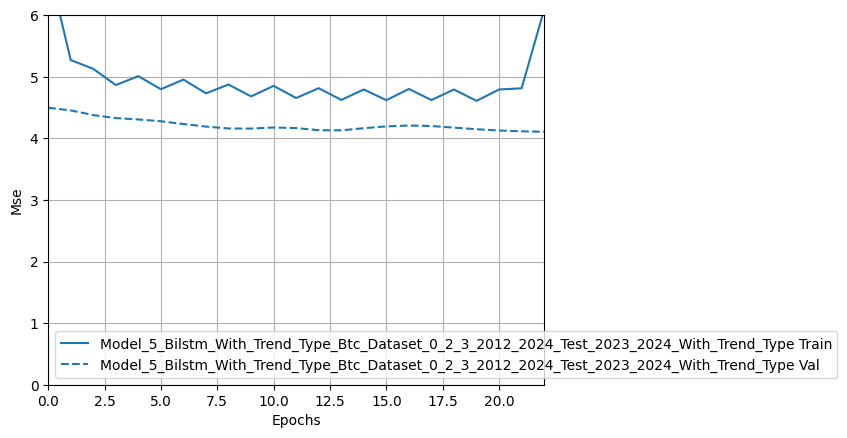

In [34]:
plotter = tfdocs.plots.HistoryPlotter(metric=metric_mse_name, smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0,6])

In [35]:
# train_dataset = tf.data.Dataset.load(f'{dataset_folder}/train/next_3_day_up')
# test_dataset = tf.data.Dataset.load(f'{dataset_folder}/test/next_3_day_up')
# for x_train, y_train, date_train in train_dataset.take(2):
#     pass
# for x_test, y_test, date_test in test_dataset.take(2):
#     pass
# plt.imshow(x_train)
# y_train
# plt.imshow(x_test)
# y_test

In [36]:
if model_name_saved is not None:
    print(new_model_name)

model_5_biLSTM_with_trend_type_1


In [37]:
dataset_folder

'../dataset/btc_dataset_0_2_3_2012_2024_test_2023_2024_with_trend_type'